<h1><center>
   Assignment 3 - Implementing, and using GNN architectures. <br/>
</center></h1>

<h3>Contributors</h3>
<dev>
<li>Eric Egli, 15-705-411</li>
<li>Kirat Virmani, 22-738-538</li>
<li>Diana Alexandra Dragos, 21-742-648</li>
<li>Abdlrahman Essa, 20-752-663</li>
<li>Hasan Atak, 20-751-897</li>
</dev>

# Theory Question 1
<img src="https://i.stack.imgur.com/HIV6k.png" width="300">

Given the graph above with and without coloring, describe which machine learning algorithms preserve the topological information irrespective of the geometric visualization. Here and in the following different colored edges represent different edge relations. Please consider the graph that is visualized and not the picture of the graph.


### Without Coloring - MLP

MLP preserves the topological information of the graph by considering the connectivity patterns between nodes. It does not rely on specific geometric visualizations or graph coloring to capture the underlying structure.

### With Coloring - GCN 

GCN can preserve the topological information while incorporating color information as node features. It leverages node and edge attributes to capture the structural patterns in the graph, making it suitable for the colored version of the graph.

# Task 1.1
Given the graph visualized in Theory Question 1. Visualize the graph in a datastructure of your choice, if your result does not match the geometry in the figure construct an isomorphism between the two graphs.

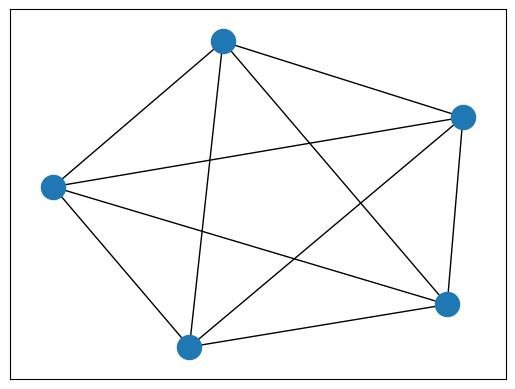

In [2]:
import networkx as nx
import numpy as np

A = np.array([
    [0, 1, 1, 1, 1],
    [1, 0, 1, 1, 1], 
    [1, 1, 0, 1, 1],
    [1, 1, 1, 0, 1],
    [1, 1, 1, 1, 0]
], dtype=float)

G = nx.Graph(A)
nx.draw_networkx(G, with_labels = False)

# Task 1.2
Given the graph shown in the image of theory question 1. Implement from scratch using <b>only numpy</b> both graph convolutions when respecting the coloring and without respecting the coloring (edge relation).

# Task 1.2.1
Graph Convolution without edge coloring.

In [3]:
# Random feature matrix 
num_nodes = A.shape[0]
num_features = 3
X = np.random.rand(num_nodes, num_features)

# Weight matrix
W = np.random.rand(num_features, num_features)

In [4]:
def graph_convolution_no_coloring(A, X, W):
    # Normalize adjacency matrix
    D = np.diag(np.sum(A, axis=1))
    D_inv_sqrt = np.sqrt(np.linalg.inv(D))
    A_hat = D_inv_sqrt.dot(A).dot(D_inv_sqrt)
    
    # Perform graph convolution
    X_new = A_hat.dot(X).dot(W)
    
    return X_new

In [5]:
X_new_no_coloring = graph_convolution_no_coloring(A, X, W)
print("Graph Convolution without Coloring:\n", X_new_no_coloring)

Graph Convolution without Coloring:
 [[1.0480022  0.78131168 0.48570551]
 [1.09612401 0.82445837 0.53824354]
 [0.94321838 0.70760532 0.42955306]
 [0.93927246 0.71681856 0.48725161]
 [1.13297522 0.85622263 0.56183035]]


# Task 1.2.2
Graph Convolution with edge coloring.

In [6]:
def graph_convolution_coloring(A, X, W):
    # Perform graph convolution
    X_new = A.dot(X).dot(W)
    
    return X_new

In [7]:
X_new_coloring = graph_convolution_coloring(A, X, W)
print("Graph Convolution with Coloring:\n", X_new_coloring)

Graph Convolution with Coloring:
 [[4.19200882 3.12524674 1.94282205]
 [4.38449602 3.29783347 2.15297416]
 [3.77287354 2.83042128 1.71821223]
 [3.75708986 2.86727424 1.94900645]
 [4.53190089 3.42489051 2.24732139]]


# Task 2

We will now reinterpret the exercise that we had in the last assignment.

In the following, we want to train a GNN using the [Deep Graph Library (DGL)](https://github.com/dmlc/dgl) using the data set from last week  ([Tensorflow version](https://www.tensorflow.org/datasets/catalog/yelp_polarity_reviews) and [(py)torch version](https://pytorch.org/text/stable/datasets.html#yelpreviewpolarity).

Recap:
Given the text of a review, we want to determine whether the yelp review is positive and negative. The data set is pre-split into training and test set. Please use the training data to fine-tune your model, while using the test data to evaluate your models performance. This exercise does not necessarily end in having a SOTA model, the goal is for you to use and fine-tune SOTA pretrained large language models.

Problem Setting:

The label $y$ to a Yelp review $T$ is either positive or negative. Given a Yelp Review $T$ and a polarity feedback $y$ determine whether the Review $T$ is positive or negative. The training set $\mathcal{D} = \{(T_1, y_1), \ldots, (T_N, y_N)\}$, where $T_i$ is review $i$ and $y_i$ is $T_i$'s polarity feedback. Use <b>AUC</b> as Evaluation Metric.

In the following, please solve all subtasks as well as the .

## Task 2.0
Load the Yelp Review Polarity dataset. Here it is also possible to only use part of the data (e.g. 5%)

In [43]:
#imports
from torchtext.datasets import YelpReviewPolarity
from torchtext.data.utils import get_tokenizer
from collections import defaultdict
import random
import dgl
import torch

In [47]:
# Load the YelpReviewPolarity dataset
train_iter, test_iter = YelpReviewPolarity()

# Create tokenizer
tokenizer = get_tokenizer('basic_english')

# Convert iterables to lists
train_list = list(train_iter)
test_list = list(test_iter)

# use 5% of the data
train_size = int(len(train_list) * 0.05) 
train_sample = random.sample(train_list, train_size)

# Separate the labels and the texts
train_labels, train_texts = zip(*train_sample)

# Convert labels to int and texts to list of words
train_labels = [int(label) for label in train_labels]
train_texts = [tokenizer(text) for text in train_texts]

## Task 2.1
Reinterpret the text data as graph data using DGL.

In [46]:
# Create a dictionary to store word to index mapping
word_to_idx = defaultdict(lambda: len(word_to_idx))

# Tokenize the reviews and map each word to an unique index
train_texts_tokenized = [[word_to_idx[word] for word in review] for review in train_texts]

# flatten the list
flat_list = [word for review in train_texts_tokenized for word in review]

# Create the source and target node lists for edges in the graph
src_nodes = []
tgt_nodes = []
for i, review in enumerate(train_texts_tokenized):
    for word in review:
        src_nodes.append(i)
        tgt_nodes.append(len(train_texts) + word)

word_features = torch.zeros(len(word_to_idx), dtype=torch.long)

features = torch.cat([torch.tensor(train_labels), word_features])

# Add features or labels to nodes
g.ndata['label'] = features

## Task 2.2

Split the data according to your evaluation protocol. Explain whether this task is inductive or transductive.

## Task 2.3
Implement, evaluate (with the evaluation protocol you defined in Theory Question 2) and train a GCN architecture for the Yelp data set and the problem setting defined above.

# Theory Question 2
Given a graph with N vertices and M edges, for three different aggregation functions prove that they are permutation invariant.

Given a graph with N vertices and M edges, naive graph convolution for a node $x_v$ with the sum aggregation function is defined as:

\begin{align*}
f(x_v)=\sigma\Bigl(x_v,\sum_{j\in N(v)}c_{jv}\phi(x_j)\Bigr)
\end{align*}

where $N(v)$ is the set of neighbors of node $v$, $c_{jv}$ is the edge weight between node $j$ and $v$, $\phi(\cdot)$ is any learnable function and $\sigma(\cdot)$ is an activation function.

We can trivially assume $N(v)$ to be the set of $\textit{all}$ nodes $N$ in the graph to show that aggregation over a the entire graph follows the same logic as over a subgraph/neighborhood.

Let us denote an arbitrary aggregation function as $agg(\cdot)$ and $c_{jv}\phi(x_j)$ as $C_{jv}$. Then, naive graph convolution can be written as:

\begin{align*}
f(x_v)=\sigma\Bigl(x_v,\underset{j \in N(v)}{agg}C_{jv}\Bigr)
\end{align*}

### Permutation invariance of sum aggregation

\begin{align*}
f(x_v)&=\sigma\Bigl(x_v,\sum_{j \in N(v)}C_{jv}\Bigr) & \\
    &=\sigma\Bigl(C_{1v} + C_{2v} + \cdots + C_{Nv}\Bigr) &\\
    &=\sigma\Bigl(C_{Nv} + C_{(N-1)v} + \cdots + C_{1v}\Bigr) & |\;\text{Since addition is commutative}\\
    &=\sigma\Bigl(x_v,\sum_{j \in N(v)}C_{jv}\Bigr) & \\
    &=f(x_v)\\
\end{align*}
This proof is based on the commutativity of the addition of natural numbers.

### Permutation invariance of product aggregation

\begin{align*}
f(x_v)&=\sigma\Bigl(x_v,\prod_{j \in N(v)}C_{jv}\Bigr) & \\
    &=\sigma\Bigl(C_{1v} \cdot C_{2v} \cdot \cdots \cdot C_{Nv}\Bigr) &\\
    &=\sigma\Bigl(C_{Nv} \cdot C_{(N-1)v} \cdot \cdots \cdot C_{1v}\Bigr) & |\;\text{Since multiplication is commutative}\\
    &=\sigma\Bigl(x_v,\prod_{j \in N(v)}C_{jv}\Bigr) & \\
    &=f(x_v)\\
\end{align*}

This proof is based on the commutativity of the multiplication of natural numbers.


### Permutation invariance of max aggregation



\begin{align*}
f(x_v)&=\sigma\Bigl(x_v,\underset{j \in N(v)}{\max}C_{jv}\Bigr) & \\
    &=\sigma\Bigl(\max(\{C_{1v}, C_{2v}, \cdots, C_{Nv}\})\Bigr) &\\
    &=\sigma\Bigl(\max(\{C_{Nv}, C_{(N-1)v}, \cdots, C_{1v}\})\Bigr) & |\;\text{Since the $\max$ function is commutative}\\
    &=\sigma\Bigl(x_v,\underset{j \in N(v)}{\max}C_{jv}\Bigr) & \\
    &=f(x_v)\\
\end{align*}
This proof is based on the commutativity of the $\max$ function.

# Task 3
In the following,  we will use a dataset as well as pre-defined task. You can find the dataset as well as the task under ogbl-collab [here](https://ogb.stanford.edu/docs/linkprop/#ogbl-collab). Split the data, use their evaluation metric as well as train a GCN for link prediction. 

 (Copy paste from the website)

**Graph**: The ogbl-collab dataset is an undirected graph, representing a subset of the collaboration network between authors indexed by MAG. Each node represents an author and edges indicate the collaboration between authors. All nodes come with 128-dimensional features, obtained by averaging the word embeddings of papers that are published by the authors. All edges are associated with two meta-information: the year and the edge weight, representing the number of co-authored papers published in that year. The graph can be viewed as a dynamic multi-graph since there can be multiple edges between two nodes if they collaborate in more than one year.

**Prediction task**: The task is to predict the future author collaboration relationships given the past collaborations. The goal is to rank true collaborations higher than false collaborations. Specifically, we rank each true collaboration among a set of 100,000 randomly-sampled negative collaborations, and count the ratio of positive edges that are ranked at K-place or above (Hits@K). We found K = 50 to be a good threshold in our preliminary experiments.

**Dataset splitting**: We split the data according to time, in order to simulate a realistic application in collaboration recommendation. Specifically, we use the collaborations until 2017 as training edges, those in 2018 as validation edges, and those in 2019 as test edges.

# Task 3.1
Load and split the data

In [1]:
! pip install ogb --quiet
# first unininstall then install the cuda version of dgl
! pip uninstall dgl -y
! pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html 

Found existing installation: dgl 1.1.0+cu118
Uninstalling dgl-1.1.0+cu118:
  Successfully uninstalled dgl-1.1.0+cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
  Using cached https://data.dgl.ai/wheels/cu118/dgl-1.1.0%2Bcu118-cp310-cp310-manylinux1_x86_64.whl (86.4 MB)


In [2]:
from ogb.linkproppred import DglLinkPropPredDataset, Evaluator
from dgl.nn.pytorch import GraphConv
from dgl.dataloading.negative_sampler import GlobalUniform
import dgl

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch.utils.data import DataLoader

import pickle
import json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# load and display dataset
dataset = "ogbl-collab"
dataset_obj = DglLinkPropPredDataset(name=dataset)

dataset_obj.meta_info

eval metric                                                        hits@50
task type                                                  link prediction
download_name                                                       collab
version                                                                  1
url                      http://snap.stanford.edu/ogb/data/linkproppred...
add_inverse_edge                                                      True
has_node_attr                                                         True
has_edge_attr                                                        False
split                                                                 time
additional node files                                                 None
additional edge files                                edge_weight,edge_year
is hetero                                                            False
binary                                                               False
Name: ogbl-collab, dtype:

In [5]:
# split data into train, valid, test
split_edge = dataset_obj.get_edge_split()
train_edge, valid_edge = split_edge["train"], split_edge["valid"]

# the training edges are up until 2017, validation edges are 2018,
# test edges are 2019
train_edge, valid_edge

({'edge': tensor([[150989, 224881],
          [150989, 224881],
          [180078, 199043],
          ...,
          [ 60425, 221741],
          [135758, 221741],
          [140614, 207232]]),
  'weight': tensor([2, 1, 1,  ..., 1, 1, 1]),
  'year': tensor([2004, 2002, 2015,  ..., 2006, 2006, 1984])},
 {'edge': tensor([[ 49077, 199043],
          [148278, 147915],
          [100860, 136989],
          ...,
          [145209,  15870],
          [ 32751,  15870],
          [ 32552,  15870]]),
  'weight': tensor([1, 1, 2,  ..., 1, 1, 1]),
  'year': tensor([2018, 2018, 2018,  ..., 2018, 2018, 2018]),
  'edge_neg': tensor([[ 38605,  43566],
          [213250, 225425],
          [132174, 208876],
          ...,
          [ 54891, 229399],
          [ 19173, 212241],
          [162412, 204275]])})

In [6]:
# prepare random sample of the training data which will be used to measure 
# the models performance on the train dataset
idx = torch.randperm(train_edge["edge"].size(0))
idx = idx[: valid_edge["edge"].size(0)]
split_edge["eval_train"] = {"edge": train_edge["edge"][idx]}

# Task 3.2
Implement, train and evaluate using the data (from Task 4.1.) a GCN using the edge and node information in a geometric DL package of your choice.

Tutorial: https://docs.dgl.ai/tutorials/blitz/4_link_predict.html#sphx-glr-tutorials-blitz-4-link-predict-py

Our solution was inspired and partyl adopted by the examples of the dgl library authors: https://github.com/dmlc/dgl/tree/master/examples/pytorch

In [10]:
class GCN(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        dropout,
    ):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()  # Define list for GraphConv layers
        self.linears = torch.nn.ModuleList()  # Define list for Linear layers

        # First GraphConv layer (input layer)
        self.convs.append(GraphConv(in_channels, hidden_channels))

        # Additional GraphConv layer
        self.convs.append(GraphConv(hidden_channels, hidden_channels))

        # Linear layers
        self.linears.append(Linear(hidden_channels, hidden_channels))
        self.linears.append(Linear(hidden_channels, hidden_channels))

        # Output layer (GraphConv)
        self.out_conv = GraphConv(hidden_channels, out_channels)

        # Dropout for regularization
        self.dropout = dropout

    def forward(self, g, x):
        # Passing input through GraphConv layers with activation and dropout
        for conv in self.convs:
            x = conv(g, x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Passing intermediate results through Linear layers with activation and dropout
        for linear in self.linears:
            x = linear(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Output layer
        x = self.out_conv(g, x)

        return x


class LinkPredictor(torch.nn.Module):
    def __init__(
        self, in_channels, hidden_channels, dropout
    ):
        super(LinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()  # Define list for Linear layers

        # Linear layers
        self.lins.append(Linear(in_channels, hidden_channels))
        self.lins.append(Linear(hidden_channels, hidden_channels))

        # output is a single probability
        self.lins.append(Linear(hidden_channels, 1))

        # Dropout for regularization
        self.dropout = dropout

    def forward(self, x_i, x_j):
        # Predict edge existence probability using element-wise product
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)

        return torch.sigmoid(x)  # Return edge existence probability


# Function to train the model
def train(model, predictor, graph, x, train_edge, optimizer, batch_size):
    # Switch models to training mode
    model.train()
    predictor.train()

    # Retrieve positive training edges and initialize negative sampler
    pos_train_edge = train_edge["edge"].to(x.device)
    neg_sampler = GlobalUniform(1)

    # Initialize loss and example count
    total_loss = total_examples = 0

    # Iterate over data in batches
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size, shuffle=True):
        # Reset gradients
        optimizer.zero_grad()

        # Compute graph embeddings
        h = model(graph, x)

        # Process positive edges
        edge = pos_train_edge[perm].t()
        pos_out = predictor(h[edge[0]], h[edge[1]])
        pos_loss = -torch.log(pos_out + 1e-15).mean()

        # sample negative edges (needed for training)
        edge = neg_sampler(graph, edge[0])
        neg_out = predictor(h[edge[0]], h[edge[1]])
        neg_loss = -torch.log(1 - neg_out + 1e-15).mean()

        # Compute loss, backpropagate and update weights
        loss = pos_loss + neg_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
        optimizer.step()

        # Update total loss and example count
        num_examples = pos_out.size(0)
        total_loss += loss.item() * num_examples
        total_examples += num_examples

    # Return average loss
    return total_loss / total_examples


# Function to evaluate the model
@torch.no_grad()
def eval(model, predictor, graph, x, split_edge, evaluator, batch_size):
    # Switch models to evaluation mode
    model.eval()
    predictor.eval()

    # Compute graph embeddings
    h = model(graph, x)

    # Retrieve evaluation edges
    pos_train_edge = split_edge["eval_train"]["edge"].to(h.device)
    pos_valid_edge = split_edge["valid"]["edge"].to(h.device)
    neg_valid_edge = split_edge["valid"]["edge_neg"].to(h.device)
    pos_test_edge = split_edge["test"]["edge"].to(h.device)
    neg_test_edge = split_edge["test"]["edge_neg"].to(h.device)

    # Helper function to compute predictions for a set of edges
    def get_pred(test_edges, h):
        preds = []
        for perm in DataLoader(range(test_edges.size(0)), batch_size):
            edge = test_edges[perm].t()
            preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
        return torch.cat(preds, dim=0)

    # Compute predictions for each evaluation set
    pos_train_pred = get_pred(pos_train_edge, h)
    pos_valid_pred = get_pred(pos_valid_edge, h)
    neg_valid_pred = get_pred(neg_valid_edge, h)
    pos_test_pred = get_pred(pos_test_edge, h)
    neg_test_pred = get_pred(neg_test_edge, h)

    # Evaluate performance
    results = {}
    for K in [50, 100]:
        evaluator.K = K
        train_hits = evaluator.eval(
            {
                "y_pred_pos": pos_train_pred,
                "y_pred_neg": neg_valid_pred,
            }
        )[f"hits@{K}"]
        valid_hits = evaluator.eval(
            {
                "y_pred_pos": pos_valid_pred,
                "y_pred_neg": neg_valid_pred,
            }
        )[f"hits@{K}"]
        test_hits = evaluator.eval(
            {
                "y_pred_pos": pos_test_pred,
                "y_pred_neg": neg_test_pred,
            }
        )[f"hits@{K}"]

        results[f"Hits@{K}"] = (train_hits, valid_hits, test_hits)

    return results

In [11]:
# hyperparams
NUM_LAYERS = 3
HIDDEN_CHANNELS = 256
DROPOUT = 0.2
BATCH_SIZE = 32768
LEARNING_RATE = 0.001
EPOCHS = 700

In [12]:
# train and evaluate the model
graph = dataset_obj[0]  # graph with only training set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# get input channel size for neural net
in_channels = graph.ndata["feat"].size(-1)

graph = dgl.add_self_loop(graph)
model = GCN(
    in_channels,
    HIDDEN_CHANNELS,
    HIDDEN_CHANNELS,
    DROPOUT,
)

predictor = LinkPredictor(HIDDEN_CHANNELS, HIDDEN_CHANNELS, DROPOUT)

graph, model, predictor = map(lambda x: x.to(device), (graph, model, predictor))

# node features for training
x_train = graph.ndata["feat"]

evaluator = Evaluator(name=dataset)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=LEARNING_RATE
)

results = []
for epoch in range(1, 1 + EPOCHS):
    loss = train(
        model,
        predictor=predictor,
        graph=graph,
        x=x_train,
        train_edge=train_edge,
        optimizer=optimizer,
        batch_size=BATCH_SIZE,
    )
    result = eval(
        model=model,
        predictor=predictor,
        graph=graph,
        x=x_train,
        split_edge=split_edge,
        evaluator=evaluator,
        batch_size=BATCH_SIZE,
    )

    # pretty-printing training and validation results
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}")

    header = "| {:^10} | {:^10} | {:^10} | {:^10} |".format(
        "Measure", "Train", "Valid", "Test"
    )
    line = "-" * len(header)

    print(line)
    print(header)
    print(line)

    train_hits_50, valid_hits_50, test_hits_50 = result["Hits@50"]
    data_line_50 = "| {:^10s} | {:^9.1f}% | {:^9.1f}% | {:^9.1f}% |".format(
        "Hits@50", train_hits_50 * 100, valid_hits_50 * 100, test_hits_50 * 100
    )
    print(data_line_50)

    train_hits_100, valid_hits_100, test_hits_100 = result["Hits@100"]
    data_line_100 = "| {:^10s} | {:^9.1f}% | {:^9.1f}% | {:^9.1f}% |".format(
        "Hits@100", train_hits_100 * 100, valid_hits_100 * 100, test_hits_100 * 100
    )
    print(data_line_100)
    print(line)

    # save results for later analysis
    results.append(result)
    # with open("./t3_results.pickle", "wb") as f:
    #     pickle.dump(results, f)
    with open("/content/drive/MyDrive/aml/t3_results.pickle", "wb") as f:
      pickle.dump(results, f)

Epoch: 01, Loss: 1.1983
-----------------------------------------------------
|  Measure   |   Train    |   Valid    |    Test    |
-----------------------------------------------------
|  Hits@50   |    5.7   % |    5.8   % |    5.7   % |
|  Hits@100  |    7.7   % |    7.9   % |    7.7   % |
-----------------------------------------------------
Epoch: 02, Loss: 0.9159
-----------------------------------------------------
|  Measure   |   Train    |   Valid    |    Test    |
-----------------------------------------------------
|  Hits@50   |    6.3   % |    4.0   % |    4.0   % |
|  Hits@100  |    9.6   % |    6.4   % |    6.2   % |
-----------------------------------------------------
Epoch: 03, Loss: 0.6851
-----------------------------------------------------
|  Measure   |   Train    |   Valid    |    Test    |
-----------------------------------------------------
|  Hits@50   |    8.9   % |    9.0   % |    8.7   % |
|  Hits@100  |   12.2   % |   12.7   % |   12.1   % |
----------

In [13]:
# if you don't want to train the model yourself, you can load the
# results from the pickle file

def dump_metrics_from_log(path):
    with open(path, 'rb') as f:
        result = pickle.load(f)
        # array format: [train, valid, test]

    for epoch, res in enumerate(result):
        print(f'Epoch {epoch}', json.dumps(res, indent=4))

# dump_metrics_from_log('./t3_results.pickle')
dump_metrics_from_log('/content/drive/MyDrive/aml/t3_results.pickle')

Streaming output truncated to the last 5000 lines.
        0.4342204666623497
    ],
    "Hits@100": [
        0.8870914053658212,
        0.5871613075028294,
        0.5043709123874894
    ]
}
Epoch 284 {
    "Hits@50": [
        0.7715531589108582,
        0.526130084548299,
        0.4514235144294071
    ],
    "Hits@100": [
        0.8479462086412356,
        0.5919213101657679,
        0.5177318742040623
    ]
}
Epoch 285 {
    "Hits@50": [
        0.7463551028560016,
        0.5054590240330205,
        0.43126335556562845
    ],
    "Hits@100": [
        0.851391385393782,
        0.5955329205778577,
        0.5195449934166505
    ]
}
Epoch 286 {
    "Hits@50": [
        0.8024266027561414,
        0.5106351108448173,
        0.4343499751775346
    ],
    "Hits@100": [
        0.8855935024299314,
        0.5916217295785899,
        0.5116881434954348
    ]
}
Epoch 287 {
    "Hits@50": [
        0.7808235137474203,
        0.5262965182078424,
        0.45120766690409897
    ],
   

# TODO: Write a short summary of the performance and why the performance metric was chosen (original metric)

# Task 4
Please describe your team's implementation of this project, including your personal contribution, in 1000-1500 characters. Each team member must explain the main aspects of the team's implementation, and may not discuss this summary with other students. You are allowed to use figures and tables to clarify. This summary constitutes a separately and individually graded piece of work.

# Bonus Task:

BT 1: Find a useful task where you can combine Transformers and GNNs/Graphs. Explain as clearly as possible why your approach makes sense. This approach should not be given in literature.

BT 2: Implement your idea/approach. 